# Description

Generates the figure for top cell types for a specified LV (in Settings section below).

# Modules loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from data.recount2 import LVAnalysis
from utils import chunker
import conf

# Settings

In [3]:
LV_NAME = "LV730"

In [4]:
LV_AXIS_THRESHOLD = 3.0
N_TOP_SAMPLES = 400
N_TOP_ATTRS = 25

In [5]:
OUTPUT_FIGURES_DIR = Path(
    conf.MANUSCRIPT["FIGURES_DIR"], "lvs_analysis", f"{LV_NAME.lower()}"
).resolve()
display(OUTPUT_FIGURES_DIR)
OUTPUT_FIGURES_DIR.mkdir(parents=True, exist_ok=True)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier_manuscript/content/images/lvs_analysis/lv730')

In [6]:
OUTPUT_CELL_TYPE_FILEPATH = OUTPUT_FIGURES_DIR / f"{LV_NAME.lower()}-cell_types.svg"
display(OUTPUT_CELL_TYPE_FILEPATH)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier_manuscript/content/images/lvs_analysis/lv730/lv730-cell_types.svg')

# Load MultiPLIER summary

In [7]:
multiplier_model_summary = pd.read_pickle(conf.MULTIPLIER["MODEL_SUMMARY_FILE"])

In [8]:
multiplier_model_summary.shape

(2157, 5)

In [9]:
multiplier_model_summary.head()

,pathway,LV index,AUC,p-value,FDR
1,KEGG_LYSINE_DEGRADATION,1,0.388059,0.866078,0.956005
2,REACTOME_MRNA_SPLICING,1,0.733057,0.000048,0.000582
3,MIPS_NOP56P_ASSOCIATED_PRE_RRNA_COMPLEX,1,0.680555,0.001628,0.011366
4,KEGG_DNA_REPLICATION,1,0.549473,0.312155,0.539951
5,PID_MYC_ACTIVPATHWAY,1,0.639303,0.021702,0.083739


# Load data

## Original data

In [10]:
INPUT_SUBSET = "z_score_std"

In [11]:
INPUT_STEM = "projection-smultixcan-efo_partial-mashr-zscores"

In [12]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    f"{INPUT_SUBSET}-{INPUT_STEM}.pkl",
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/bases_data/base_orig/results/data_transformations/z_score_std/z_score_std-projection-smultixcan-efo_partial-mashr-zscores.pkl')

'z_score_std-projection-smultixcan-efo_partial-mashr-zscores'

In [13]:
data = pd.read_pickle(input_filepath)

In [14]:
data.shape

(3752, 987)

In [15]:
data.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
100001_raw-Food_weight,-0.695006,1.962565,0.057683,0.878731,-0.539977,1.481272,-0.396422,1.090180,0.759223,0.931395,...,1.129784,1.752343,-1.411403,2.823863,0.931116,-1.054519,0.432982,-0.633597,0.554279,-0.642479
100002_raw-Energy,-1.528127,-0.345309,-0.148953,-0.242060,0.373427,0.791092,0.263477,0.987702,0.354391,1.416059,...,0.224604,0.769882,-0.509482,0.091153,2.286789,-1.008256,-0.029764,1.737229,-0.272107,-0.526125
100003_raw-Protein,-0.704572,-1.011299,0.671420,0.143991,0.615212,0.874212,-0.040998,0.915170,0.254369,-0.084237,...,1.003019,1.044314,-2.376108,0.004778,0.053714,-0.892447,-0.183800,1.377991,-0.278794,-0.419733
100004_raw-Fat,-0.989832,-1.875490,0.261555,-1.420719,0.366238,1.167049,0.257387,0.717674,-0.997664,0.969825,...,0.585913,0.638314,0.119139,-0.140204,1.394326,-1.173402,0.555058,1.013982,-0.544506,-0.064061
100005_raw-Carbohydrate,-0.580143,0.243335,0.158966,-0.036558,0.068176,-0.202639,1.101281,0.675227,1.463432,1.010078,...,-0.249108,-0.026814,0.232713,0.323682,1.168642,-0.282935,0.653105,1.909526,0.199997,-1.656894


## LV data

In [16]:
lv_obj = LVAnalysis(LV_NAME, data)

In [17]:
multiplier_model_summary[
    multiplier_model_summary["LV index"].isin((LV_NAME[2:],))
    & (
        (multiplier_model_summary["FDR"] < 0.05)
        | (multiplier_model_summary["AUC"] >= 0.75)
    )
]

[2021-08-02 13:53:29,904 - numexpr.utils] INFO: NumExpr defaulting to 8 threads.


,pathway,LV index,AUC,p-value,FDR
1705,DMAP_MEGA2,730,0.819755,0.000002,0.000026


In [18]:
lv_data = lv_obj.get_experiments_data()

SRP057500, SRP053296, SRP056295, SRP062023, SRP042161, SRP042596, SRP041988, SRP059205, SRP050499, SRP018403, SRP014620, SRP057196, SRP062025, SRP055569, SRP060355, SRP058667, SRP063493, SRP021085, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (17 != 18)
  warnings.warn(


In [19]:
lv_data.shape

(3508, 31)

In [20]:
lv_data.head()

batch    cancer type     cell type  \
project   run                                                
SRP057500 SRR1982614  Batch04  Hepatobiliary  Thrombocytes   
          SRR1982613  Batch04  Hepatobiliary  Thrombocytes   
          SRR1982612  Batch03  Hepatobiliary  Thrombocytes   
          SRR1982611  Batch03  Hepatobiliary  Thrombocytes   
          SRR1982610  Batch03  Hepatobiliary  Thrombocytes   

                     mutational subclass patient id tissue tissue derivation  \
project   run                                                                  
SRP057500 SRR1982614                  wt   Chol-442  blood               NaN   
          SRR1982613                KRAS   Chol-410  blood               NaN   
          SRR1982612                  wt   Chol-379  blood               NaN   
          SRR1982611                  wt   Chol-376  blood               NaN   
          SRR1982610                  wt   Chol-341  blood               NaN   

                     cell line subtype collectiondate  ...  \
project   run                                          ...   
SRP057500 SRR1982614       NaN     NaN            NaN  ...   
          SRR1982613       NaN     NaN            NaN  ...   
          SRR1982612       NaN     NaN            NaN  ...   
          SRR1982611       NaN     NaN            NaN  ...   
          SRR1982610       NaN     NaN            NaN  ...   

                     experiment_sample_name phenotype cell phenotype  \
project   run                                                          
SRP057500 SRR1982614                    NaN       NaN            NaN   
          SRR1982613                    NaN       NaN            NaN   
          SRR1982612                    NaN       NaN            NaN   
          SRR1982611                    NaN       NaN            NaN   
          SRR1982610                    NaN       NaN            NaN   

                     tissue type tissue subtype  tag disease state  \
project   run                                                        
SRP057500 SRR1982614         NaN            NaN  NaN           NaN   
          SRR1982613         NaN            NaN  NaN           NaN   
          SRR1982612         NaN            NaN  NaN           NaN   
          SRR1982611         NaN            NaN  NaN           NaN   
          SRR1982610         NaN            NaN  NaN           NaN   

                     sf3b1 mutation treatment     LV730  
project   run                                            
SRP057500 SRR1982614            NaN       NaN  0.531810  
          SRR1982613            NaN       NaN  1.075190  
          SRR1982612            NaN       NaN  0.668744  
          SRR1982611            NaN       NaN  0.925050  
          SRR1982610            NaN       NaN  0.804031  

[5 rows x 31 columns]

# LV cell types analysis

## Get top attributes

In [21]:
lv_attrs = lv_obj.get_attributes_variation_score()
display(lv_attrs.head(20))

batch                        0.191813
mutational subclass          0.191813
cancer type                  0.191813
patient id                   0.166939
tissue                       0.119182
cell type                    0.068996
origin                       0.018848
cell origin                  0.018848
description                  0.018848
tissue subtype               0.009060
tag                          0.009060
tissue type                  0.009060
collectiondate               0.006185
rin                          0.006185
antibody used for sorting    0.006066
activation                   0.003325
cell line                    0.003235
phenotype                    0.003141
cell phenotype               0.003141
disease state                0.002560
dtype: float64

In [22]:
# show those with cell type or tissue in their name
_tmp = pd.Series(lv_attrs.index)
lv_attrs[
    _tmp.str.match(
        "(?:cell.+type$)|(?:tissue$)|(?:tissue.+type$)",
        case=False,
        flags=re.IGNORECASE,
    ).values
].sort_values(ascending=False)

tissue            0.119182
cell type         0.068996
tissue type       0.009060
tissue subtype    0.009060
cell phenotype    0.003141
dtype: float64

In [23]:
_tmp = lv_data.loc[
    :,
    [
        "cell type",
        "tissue",
        "cancer type",
        "mutational subclass",
        LV_NAME,
    ],
]

In [24]:
_tmp_seq = list(chunker(_tmp.sort_values(LV_NAME, ascending=False), 25))

In [25]:
_tmp_seq[1]

cell type tissue cancer type mutational subclass  \
project   run                                                               
SRP057500 SRR1982649  Thrombocytes  blood         CRC                KRAS   
          SRR1982803  Thrombocytes  blood    Pancreas                KRAS   
          SRR1982595  Thrombocytes  blood      Breast                  wt   
          SRR2096494  thrombocytes  blood      Breast                  wt   
          SRR1982588  Thrombocytes  blood      Breast               HER2+   
          SRR1982629  Thrombocytes  blood         CRC                  wt   
          SRR1982709  Thrombocytes  blood          HC                  wt   
          SRR1982801  Thrombocytes  blood    Pancreas                  wt   
          SRR1982632  Thrombocytes  blood         CRC                  wt   
          SRR1982789  Thrombocytes  blood        Lung                EGFR   
          SRR1982680  Thrombocytes  blood         GBM                  wt   
          SRR1982827  Thrombocytes  blood    Pancreas                KRAS   
          SRR1982625  Thrombocytes  blood         CRC                KRAS   
          SRR1982673  Thrombocytes  blood         GBM                  wt   
          SRR1982808  Thrombocytes  blood    Pancreas                  wt   
          SRR1982597  Thrombocytes  blood      Breast              PIK3CA   
          SRR1982642  Thrombocytes  blood         CRC                KRAS   
          SRR1982706  Thrombocytes  blood          HC                  wt   
          SRR1982825  Thrombocytes  blood    Pancreas                KRAS   
          SRR1982810  Thrombocytes  blood    Pancreas                  wt   
          SRR1982658  Thrombocytes  blood         GBM                  wt   
          SRR1982626  Thrombocytes  blood         CRC                  wt   
          SRR1982586  Thrombocytes  blood      Breast               HER2+   
          SRR1982589  Thrombocytes  blood      Breast     Triple Negative   
          SRR1982818  Thrombocytes  blood    Pancreas                KRAS   

                         LV730  
project   run                   
SRP057500 SRR1982649  1.295861  
          SRR1982803  1.294968  
          SRR1982595  1.284191  
          SRR2096494  1.269344  
          SRR1982588  1.269197  
          SRR1982629  1.268847  
          SRR1982709  1.267296  
          SRR1982801  1.265849  
          SRR1982632  1.255575  
          SRR1982789  1.232940  
          SRR1982680  1.212451  
          SRR1982827  1.212384  
          SRR1982625  1.211833  
          SRR1982673  1.208108  
          SRR1982808  1.204881  
          SRR1982597  1.192045  
          SRR1982642  1.189134  
          SRR1982706  1.174654  
          SRR1982825  1.171780  
          SRR1982810  1.168332  
          SRR1982658  1.158072  
          SRR1982626  1.157365  
          SRR1982586  1.151008  
          SRR1982589  1.133809  
          SRR1982818  1.127333

In [26]:
# what is there in these projects?
lv_data.loc[["SRP057500"]].dropna(how="all", axis=1).sort_values(
    LV_NAME, ascending=False
).sort_values(LV_NAME, ascending=False).head(10)

batch cancer type     cell type mutational subclass  \
project   run                                                                 
SRP057500 SRR1982661  Batch02         GBM  Thrombocytes                  wt   
          SRR1982667  Batch02         GBM  Thrombocytes                  wt   
          SRR1982782  Batch03        Lung  Thrombocytes                  wt   
          SRR1982788  Batch03        Lung  Thrombocytes           EGFR, MET   
          SRR1982666  Batch02         GBM  Thrombocytes                  wt   
          SRR1982638  Batch03         CRC  Thrombocytes                KRAS   
          SRR1982660  Batch03         GBM  Thrombocytes                  wt   
          SRR1982676  Batch02         GBM  Thrombocytes                  wt   
          SRR1982813  Batch03    Pancreas  Thrombocytes                KRAS   
          SRR1982800  Batch03    Pancreas  Thrombocytes                  wt   

                     patient id tissue     LV730  
project   run                                     
SRP057500 SRR1982661    GBM-378  blood  1.869723  
          SRR1982667    GBM-406  blood  1.850733  
          SRR1982782    Lung-30  blood  1.703482  
          SRR1982788    Lung-61  blood  1.658324  
          SRR1982666    GBM-402  blood  1.624695  
          SRR1982638    CRC-466  blood  1.568141  
          SRR1982660    GBM-372  blood  1.536974  
          SRR1982676    GBM-430  blood  1.532860  
          SRR1982813   Panc-391  blood  1.507183  
          SRR1982800   Panc-328  blood  1.499616

In [27]:
SELECTED_ATTRIBUTE = "cell type"

In [28]:
# it has to be in the order desired for filling nans in the SELECTED_ATTRIBUTE
SECOND_ATTRIBUTES = ["tissue"]

## Get plot data

In [29]:
plot_data = lv_data.loc[:, [SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES + [LV_NAME]]

In [30]:
# if blank/nan, fill cell type column with tissue content
_new_column = plot_data[[SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES].fillna(
    method="backfill", axis=1
)[SELECTED_ATTRIBUTE]
plot_data[SELECTED_ATTRIBUTE] = _new_column
plot_data = plot_data.drop(columns=SECOND_ATTRIBUTES)
plot_data = plot_data.fillna({SELECTED_ATTRIBUTE: "NOT CATEGORIZED"})
# plot_data = plot_data.dropna(subset=[SELECTED_ATTRIBUTE])

In [31]:
plot_data = plot_data.sort_values(LV_NAME, ascending=False)

In [32]:
plot_data.head(20)

cell type     LV730
project   run                               
SRP057500 SRR1982661  Thrombocytes  1.869723
          SRR1982667  Thrombocytes  1.850733
          SRR1982782  Thrombocytes  1.703482
          SRR1982788  Thrombocytes  1.658324
          SRR1982666  Thrombocytes  1.624695
          SRR1982638  Thrombocytes  1.568141
          SRR1982660  Thrombocytes  1.536974
          SRR1982676  Thrombocytes  1.532860
          SRR1982813  Thrombocytes  1.507183
          SRR1982800  Thrombocytes  1.499616
          SRR1982713  Thrombocytes  1.482228
          SRR1982806  Thrombocytes  1.444313
          SRR1982603  Thrombocytes  1.402699
          SRR1982650  Thrombocytes  1.398294
          SRR1982592  Thrombocytes  1.391677
          SRR1982766  Thrombocytes  1.382152
          SRR1982634  Thrombocytes  1.351197
          SRR1982674  Thrombocytes  1.348668
          SRR1982804  Thrombocytes  1.345236
          SRR1982669  Thrombocytes  1.332295

## Customize x-axis values

When cell type values are not very clear, customize their names by looking at their specific studies to know exactly what the authors meant.

In [33]:
final_plot_data = plot_data.replace(
    {
        SELECTED_ATTRIBUTE: {
            "thrombocytes": "Thrombocytes",
        }
    }
)

# plot_data = plot_data[plot_data[SELECTED_ATTRIBUTE] != "no cell"]

In [34]:
# add also tissue information to these projects
_srp_code = "SRP057500"
_tmp = final_plot_data.loc[(_srp_code,)].apply(
    lambda x: x[SELECTED_ATTRIBUTE]
    + f" ({lv_data.loc[(_srp_code, x.name), 'cancer type']})",
    axis=1,
)
final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values

<ipython-input-34-fd136aef7281>:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  _tmp = final_plot_data.loc[(_srp_code,)].apply(


In [35]:
# take the top samples only
final_plot_data = final_plot_data.sort_values(LV_NAME, ascending=False)[:N_TOP_SAMPLES]

## Threshold LV values

In [36]:
final_plot_data.loc[
    final_plot_data[LV_NAME] > LV_AXIS_THRESHOLD, LV_NAME
] = LV_AXIS_THRESHOLD

## Delete samples with no tissue/cell type information

In [37]:
final_plot_data = final_plot_data[
    final_plot_data[SELECTED_ATTRIBUTE] != "NOT CATEGORIZED"
]

## Set x-axis order

In [38]:
attr_order = (
    final_plot_data.groupby(SELECTED_ATTRIBUTE)
    .max()
    .sort_values(LV_NAME, ascending=False)
    .index[:N_TOP_ATTRS]
    .tolist()
)

In [39]:
len(attr_order)

25

In [40]:
attr_order[:5]

['Thrombocytes (GBM)',
 'Thrombocytes (Lung)',
 'Thrombocytes (CRC)',
 'Thrombocytes (Pancreas)',
 'Thrombocytes (HC)']

## Plot

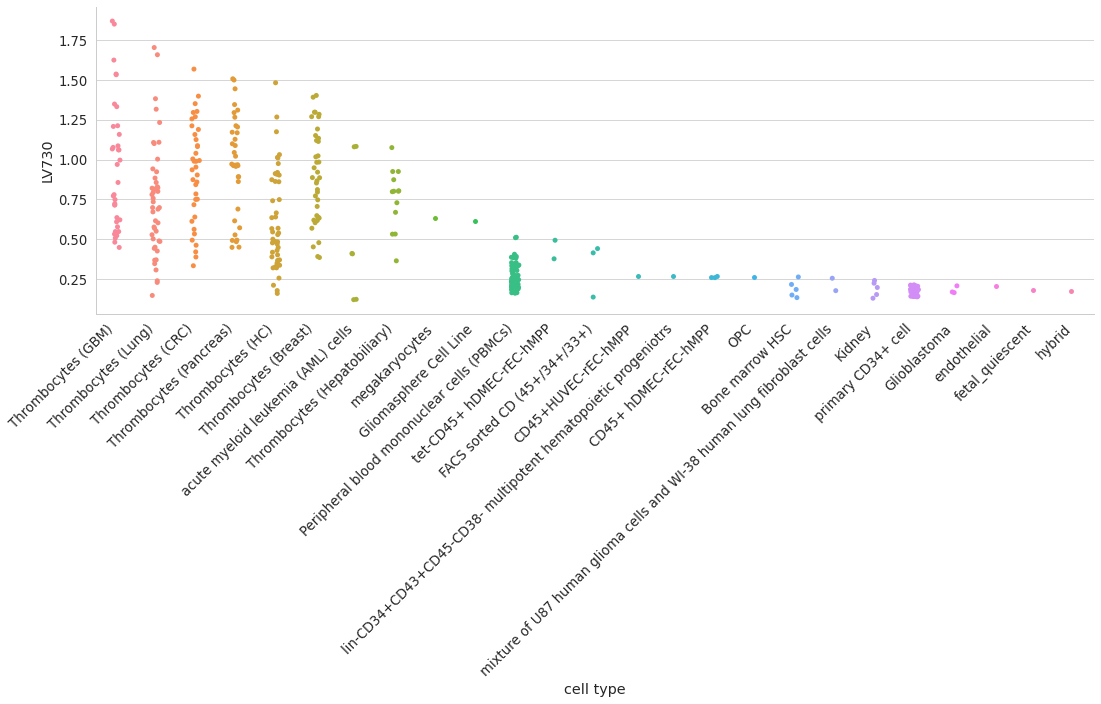

In [41]:
with sns.plotting_context("paper", font_scale=1.5), sns.axes_style("whitegrid"):
    sns.catplot(
        data=final_plot_data,
        y=LV_NAME,
        x=SELECTED_ATTRIBUTE,
        order=attr_order,
        kind="strip",
        height=5,
        aspect=3,
    )
    plt.xticks(rotation=45, horizontalalignment="right")

    plt.savefig(
        OUTPUT_CELL_TYPE_FILEPATH,
        bbox_inches="tight",
        facecolor="white",
    )

# Debug

In [42]:
# with pd.option_context(
#     "display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None
# ):
#     _tmp = final_plot_data[final_plot_data[SELECTED_ATTRIBUTE].str.contains("NOT CAT")]
#     display(_tmp.head(20))

In [43]:
# # what is there in these projects?
# lv_data.loc[["SRP050499"]].dropna(how="all", axis=1).sort_values(
#     LV_NAME, ascending=False
# ).head(60)